In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

        
# Any results you write to the current directory are saved as output.

In [2]:
#list of Libraries that need to be imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [3]:
!ls /kaggle

input  lib  working


In [4]:
#!pwd
#!ls /kaggle/input
!ls /kaggle/input/flicker8k-dataset


Flickr8k_Dataset  Flickr8k_text  flickr8k_dataset  flickr8k_text


In [5]:
# Show the first 5 files
ctr = 5
for dirname, _, filenames in os.walk('/kaggle/input/flicker8k-dataset'):
    for filename in filenames:
        if (ctr < 1):
            break
        else:
            print(os.path.join(dirname, filename))
            ctr -=1

/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/3317145805_071b15debb.jpg
/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/417577408_eb571658c1.jpg
/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/3265864834_e0229020dd.jpg
/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/3330675488_8692476a4a.jpg
/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/393284934_d38e1cd6fe.jpg


## Data Collection

In [6]:
#Read text captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [7]:
captions = readTextFile('/kaggle/input/flicker8k-dataset/flickr8k_text/Flickr8k.token.txt')
len(captions.split('\n'))

40461

Some text explanation

In [8]:
captions = captions.split('\n')[:-1]
print(captions[0]) #Caption for first image

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


We will now creat a dictionary to map each image with the list of captions it has
d[key][value]
key = ImageID
value = Array of 5 captions

To decide how to split it, we have used the cell below

In [9]:
print(captions[0].split('\t'))
#Here we require the second part and he first part with the #0 trimmed, i.e, the image ID
A,B = captions[0].split('\t')
print(A,'||',B)
A.split('.')[0]

['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']
1000268201_693b08cb0e.jpg#0 || A child in a pink dress is climbing up a set of stairs in an entry way .


'1000268201_693b08cb0e'

In [10]:
#Dictionary 
descriptions = {}

for row in captions:
    first_half,imgtext = row.split('\t')
    imgID = first_half.split('.')[0]
    
    #Adding key-value pair to dictionary
    if descriptions.get(imgID) is None:
        descriptions[imgID] = []
        
    descriptions[imgID].append(imgtext)        

In [11]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Text Cleaning

In [12]:
import cv2
import matplotlib.pyplot as plt

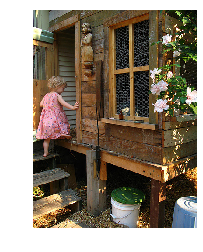

In [13]:
imgpath = '/kaggle/input/flicker8k-dataset/flickr8k_dataset/Flicker8k_Dataset/'

img  = cv2.imread(imgpath+'1000268201_693b08cb0e.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

## Data Cleaning

Generally in data cleaning, we clean using stopwords, lemmatization etc. , but in this we won't do so as we need to generate grammatically correct English text.
In this, the cleaning we can do is remove digits,punctuations,special characters and lowercase all text. This will also help reduce vocabulary size.

In [14]:
#Import Libraries
import re

In [15]:
def cleantext(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    
    #sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

In [16]:
cleantext('A 3 year old kid is running along the Grant Park')

'a year old kid is running along the grant park'

In [17]:
for imgID,captions in descriptions.items():
    for i in range (0, len(captions)):
        captions[i] = cleantext(captions[i]) 

In [18]:
descriptions['1000268201_693b08cb0e']

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [19]:
#Store all the desciptions to a text file
with open('descriptions.txt','w') as f:
    f.write(str(descriptions))

## Vocabulary

Vocabulary is the set if all unique words that the model can predict
Description -> Clean descpriotions -> Unique words
We will use these unique words to create a mapping to find the probablities of te occurence of each of the word.

In [ ]:
#Read all the desciptions from the text file
# with open('descriptions.txt','r') as f:
#     descriptions = f.read()
    
#     json_acceptable_string = descriptions.replace("'","\"")
#     descriptions = json.loads(json_acceptable_string)

# print(type(descriptions))    

In [20]:
#Vocabulary Creation

vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : ",len(vocabulary))

Vocab Size :  8441


It was observed that if single size characters are present, then the vocab size is 8441, else the size is 8424. Thus, there is a difference of 17 characters.

In [21]:
vocab = set()
vocab.update(['hello','Mango'])
vocab.update(['hello','hi'])
vocab.update(['hi'])
print(vocab)

{'hello', 'Mango', 'hi'}


In [22]:
#Total noumber of words across all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(word) for sentence in descriptions[key] for word in sentence.split()]
    
print("Total words: ", len(total_words))

Total words:  437466


With only 17 unique characters more, the total words have jumped from 373837 to 437466. This means that these single characters are very much in use.

Now, we have around 8000 unique words. To ensure that we are using the proper words, we will filter out words whose frequency < 5, i.e., they have appeared in less than 5 setences. This reduces vocab size without drastically affecting the text generation variety

In [23]:
#Filter words from the vocabulary according to certain threshold frequency
import collections

counter = collections.Counter(total_words)
frequencyCount = dict(counter)
print(len(frequencyCount.keys()))
#print(frequencyCount)

8441


In the cell below we are using lamda function, so 
('a': 20) , we need to check 20, i.e., X[1]


In [24]:
sortedFrequencyCount = sorted(frequencyCount.items(),reverse =True, key = lambda x:x[1])

#Filter
threshold = 10
sortedFrequencyCount = [x for x in sortedFrequencyCount if x[1] > threshold]
total_words = [x[0] for x in sortedFrequencyCount]


In [25]:
print(len(sortedFrequencyCount))
print(len(total_words))

1850
1850


Earlier, the difference for single characters was very high, but now we can see that many of the single characters were not in much use, so keeping them only added 5 more words in our vocabulary, with 1845 words being the case when they were absent. 
So we have reduced the vocabulary size from 8000 to around 2000 words, reducing it to less than 1/4th of the original vocabulary size.

## Loading the Training Set

Preparing Train and Test Data

we already have the files present in the dataset for train and test images seperately.

Now, we will map trained descriptions to the trained images.

In [26]:
#Read the image file
train_file_path = '/kaggle/input/flicker8k-dataset/flickr8k_text/Flickr_8k.trainImages.txt'
test_file_path = '/kaggle/input/flicker8k-dataset/flickr8k_text/Flickr_8k.testImages.txt'
 
train_file_data = readTextFile(train_file_path)
test_file_data = readTextFile(test_file_path)

In [27]:
#print(train_file_data)
#print(train_file_data[-1])
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
print(train[:10])
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


We will add a tweak realting to Text Generation. We will use a an RNN, or an LSTM to be precise

 >>>>>>>        >>>>>>>>
[ ] -> [ ] ->  [ ] ->  [ ] -> 
 ^      >>>>>>>>

We will add a start and end token to prevent it from continuing indefinitely.
So, we will provide start as an input. 


In [28]:
#Prepare descriptions for the training data

#Tweak - Add a <s> and <e> token to training data

train_descriptions = {}

for imgID in train:
    train_descriptions[imgID] = []
    for sentence in descriptions[imgID]:
        caption_to_append = 'startseq ' + sentence + ' endseq'
        train_descriptions[imgID].append(caption_to_append)

In [29]:
train_descriptions['1000268201_693b08cb0e']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

Now, each sentence now has a startseq and endseq

In [ ]:
#Transfer Learning
# Image ---> Feature
# Text ---> Feature

## Image Preprocessing

#### Image Feature Extraction

We will use Resnet - 50 model. It is a model that has skip connections

In [30]:
#Import Libraries
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [31]:
# When using Google Colab or Jupyter Notebook
# model = resnet50.ResNet50(weights='imagenet', input_shape=(224,224,3))
# model.summary()

#When using Kaggle Notebooks
model = ResNet50(weights='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

Back propagration graident is multipled by sigma (b/w 0 and 1) which leads to very much reduced value as we go further. This problem is known as vanishing gradient and we use skip connections to overcome that. Now, i the above model summary in the 'Connected To' section, we can see more than one layers mentioned, displaying the skip connections present in the network. 

We will not train our model, we will instead use the learned weights to extract features from our images. This is known as Transfer Learning.


|==================================================================================================
 activation_49 (Activation)      (None, 7, 7, 2048)   0           add_16[0][0]      
|--------------------------------------------------------------------------------------------------
avg_pool (GlobalAveragePooling2 (None, 2048)         0           activation_49[0][0]              
|__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 1000)         2049000     avg_pool[0][0]                   
|--------------------------------------------------------------------------------------------------

In activation layer, we have activation maps of 7 X 7 size with 2048 depth.

One way is to flatten the layer to get 7 x 7 x 2048 neurons, which menas large neurons in dense layers, leading to lag=rge no. of parameters
 Other war is to take avergae value of 7x 7

Now the avg_pool layer has 2048  numbers with average value from each of the 7x7. These 2048 will be our fetaure reprentation 

So, we will take a model 


In [32]:
model.layers[-2].output

<tf.Tensor 'avg_pool/Mean:0' shape=(None, 2048) dtype=float32>

In [33]:
from keras.models import Model, load_model
# from keras.preprocessing.sequenece import pad_sequences
# from keras.utils import to_categorical
# from keras.layers import Input, Dense, Dropout, Embedding, LSTM
# from keras.layers.merge import add

In [34]:
new_model = Model(model.input,model.layers[-2].output)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

Now, we will take a model , which is the Resnet50 conv base, we will input an image , preprocess it to the input size and then get a feature vector
If we input a m images, we will get a vector of size m x 2048 dimensional output, which we will store in a file.

So, we will have t

In [35]:
from keras.preprocessing import image

In [36]:
# Extract features of all images and store them in a file

def preprocess_image(img):
    img = image.load_img(img,target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis = 0)
    
# When we input images of dims (224,224,3), we need to do so in batches, which lead to dims of (batch_size,224,224,3)
# Thus, we use expand_dims to expand and add a 1 to the 0th axis, making it (1,224,224,3). We can also use a reshape 
# instead of the exppand_dims function
 
    #Normalization
    #from keras.applications.resnet50 import preprocess_input for preprocessing the input image
    img = preprocess_input(img)
    return img

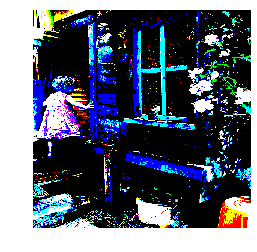

In [37]:
img = preprocess_image(imgpath+'1000268201_693b08cb0e.jpg')
plt.imshow(img[0])
plt.axis('off')
plt.show()

This is the output after preprocessing the image. We have used img[0] as the input is a 4D tensor and will return 'TypeError: Invalid dimensions for image data' otherwise

In [39]:
#print(img)
#Range of the numbers if from 255 to -255
#Most likely the preproces is finding the mean of all the channels R,G,B and subtracting it from the the original 
#values. Thus, most part of the image is dark as it is closer to the mean. The imshow function clips the negative 
#values to 0, resulting in a dark color.

In [42]:
#Preprocessing for all images to recieve an encoding,i.e, the feature vector and save it
def encodeImage(image):
    image = preprocess_image(image)
    feature_vector = new_model.predict(image)
    #print(feature_vector.shape)
    # The output is (1,2048) so we will reshape that to a single axi
    feature_vector = feature_vector.reshape((-1,))
    # Same as feature_vector = feature_vector.reshape((2048,))
    #print(feature_vector.shape)
    return feature_vector

In [43]:
encodeImage(imgpath+'1000268201_693b08cb0e.jpg')

array([0.04154301, 0.17076042, 0.29278612, ..., 0.05089623, 0.3132239 ,
       0.86007506], dtype=float32)

## Images to Features (Transfer Learning)

In [44]:
from time import time

In [45]:
start_time = time()
encoding_train = {}
# imageID --> feature vector extracted from ResNet Image

for ix, imageID in enumerate(train):
    train_imagepath = imgpath+imageID+'.jpg'
    encoding_train[imageID+'.jpg'] = encodeImage(train_imagepath)
    
    if ix%100 == 0:
        print('Encoding in Progress Time Step ', ix)
        
end_time = time()
print('Total time Taken:',end_time-start_time)

Encoding in Progress Time Step  0
Encoding in Progress Time Step  100
Encoding in Progress Time Step  200
Encoding in Progress Time Step  300
Encoding in Progress Time Step  400
Encoding in Progress Time Step  500
Encoding in Progress Time Step  600
Encoding in Progress Time Step  700
Encoding in Progress Time Step  800
Encoding in Progress Time Step  900
Encoding in Progress Time Step  1000
Encoding in Progress Time Step  1100
Encoding in Progress Time Step  1200
Encoding in Progress Time Step  1300
Encoding in Progress Time Step  1400
Encoding in Progress Time Step  1500
Encoding in Progress Time Step  1600
Encoding in Progress Time Step  1700
Encoding in Progress Time Step  1800
Encoding in Progress Time Step  1900
Encoding in Progress Time Step  2000
Encoding in Progress Time Step  2100
Encoding in Progress Time Step  2200
Encoding in Progress Time Step  2300
Encoding in Progress Time Step  2400
Encoding in Progress Time Step  2500
Encoding in Progress Time Step  2600
Encoding in P

In [46]:
import pickle

In [47]:
#Store everything to the disk

with open('encoded_train_features.pkl','wb') as f:
    pickle.dump(encoding_train,f)

In [48]:
#Repeat the same steps for test images
start_time = time()
encoding_test = {}
# imageID --> feature vector extracted from ResNet Image

for ix, imageID in enumerate(test):
    test_imagepath = imgpath+imageID+'.jpg'
    encoding_test[imageID+'.jpg'] = encodeImage(test_imagepath)
    
    if ix%100 == 0:
        print('Test Encoding in Progress Time Step ', ix)
        
end_time = time()
print('Total time Taken(test):',end_time-start_time)

with open('encoded_test_features.pkl','wb') as f:
    pickle.dump(encoding_test,f)

Test Encoding in Progress Time Step  0
Test Encoding in Progress Time Step  100
Test Encoding in Progress Time Step  200
Test Encoding in Progress Time Step  300
Test Encoding in Progress Time Step  400
Test Encoding in Progress Time Step  500
Test Encoding in Progress Time Step  600
Test Encoding in Progress Time Step  700
Test Encoding in Progress Time Step  800
Test Encoding in Progress Time Step  900
Total time Taken(test): 29.061841011047363


## Preprocessing Captions

We need to convert our captions to numerical values.

In [49]:
#Vocabulary Size
len(total_words)

1850

In [50]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

We will reserve the 0th index for padding the sentences so that all sentences are of the same length. The length of all sentence will be decided by the longest sentence.
Also, we need to add the special characters, startseq and endseq as these are not present in our list of unique total_words

In [51]:
print(word_to_idx['dog'])
print(idx_to_word[7])
print(len(idx_to_word))
print(idx_to_word[1850])

7
dog
1850
cannon


In [52]:
# Two special words
idx_to_word[1851] = 'startseq'
word_to_idx['startseq'] = 1851

idx_to_word[1852] = 'endseq'
word_to_idx['endseq'] = 1852

vocab_size = len(idx_to_word) + 1 
print('Vocabulary Size : ', vocab_size)

Vocabulary Size :  1853


We have added +1 for the padding character which will also be part of that needs to be trained. We will do a mini batch traning, so there will be multiple captions at a time. Now, lets say the lenght of RNN is x, then sentences must be of length x.
We can either fix the length for each specific batch, clipping longer sentences or fix it for the entire training set.
We will make it fixed for the entire training set, so we now how much we have to unroll the RNN or LSTM

In [ ]:
#print(train_descriptions)

In [53]:
# Find maximum length of sentence
# We are using train_descriptions instead of descriptions as we also need <s> and <e> to present in the 
# RNN inputted sentences 
maxLength = 0
for key in train_descriptions.keys():
    for caption in train_descriptions[key]:
        maxLength = max(maxLength,len(caption.split()))
        
print(maxLength)

38


## Data Loader (Generator)

We can treat image captioningIn supervised learning probelm, 

y       =     f(x)
Caption      Image

So, we need to train

Language Modelling:
P(W(t+1)| W1........Wt)

In Markov Chains, we can only see x words , but in RNN and LSTM, we can see the entire previous sentence.

Input         Y        Ypred
<\s>          Dog        Dog
<\s>Dog       was        is 
<\s>Dog was  jumping    playing
    
Even if we get the wrong value, we give the corrct input so that the model can learn the next possible word    
P(W(t+1)| W1........Wt)
Thus,
Probablity of a Sentence = [P(w1|w0) * P(w2|w0w1) * P(w3|w0w1w2) ...] -> Joint Probabibility
So, we are maximizing the probablity of a setence at train time by feeding ground truth values.
At test time, we feed the values predicted.


We will feed  partial captions with image feature vector alongside the input. So, we will create multiple training points from single caption.The training points will depend upon the no. of words in a sentence.


Size of Data Matri:
Each image vector is of length 2048 and each sentence is of length 38
Size of matrix = n * m
n = 2,10,000
m = 2048 + Caption length
Now , the words are converted to 200-long dimensional value using Embedding layer (GloVe), so
Caption Length = 34 X 200 = 6800
Thus, m = 2048 + 6800 = 8848
So, final size of data mtrix = 2,10,000 X 8848 = 1,85,80,80,000 blocks

This will require more than 3GB memory, so we will use data generators

In [54]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [55]:
def dataGenerator(train_descriptions, encoding_train, word_to_idx, maxLength, batch_size):
    X1, X2, Y = [], [], []
    
    n = 0
    while True:
        for key,caption_list in train_descriptions.items():
            n += 1
            img = encoding_train[key+'.jpg']
            
            for sentence in caption_list:
                sequence = [word_to_idx[word] for word in sentence.split() if word in word_to_idx]
                for i in range (1,len(sequence)):
                    Xi = sequence[0:i]
                    Yi = sequence[i]
                    
                    #Pad the sentence, where 0 denotes padding word
                    Xi = pad_sequences([Xi], maxlen = maxLength, value = 0, padding='post')[0]
                    Yi = to_categorical([Yi], num_classes = vocab_size)[0]
                    
                    X1.append(img)
                    X2.append(Xi)
                    Y.append(Yi)
                    
                if n == batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(Y)]        
                    X1,X2,Y = [],[],[]
                    n = 0

## Word Embeddings

In [56]:
!ls /kaggle/input/glove-global-vectors-for-word-representation/

glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.50d.txt


In [57]:
f = open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt', encoding = 'utf8')

In [58]:
embedding_index = {}
for line in f:
    values = line.split()
    print(values)
    break

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581']


As each line has a word followed by the values, 

In [59]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    embedding_index[word] = np.array(values[1:],dtype = 'float')

In [60]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [61]:
embedding_index.get('pink')

array([-1.7271e-01,  9.5417e-01, -8.4464e-01,  1.1818e-01,  8.7641e-02,
        8.4337e-01, -7.3347e-01, -1.1093e+00, -2.5643e-01,  9.7234e-02,
        1.2908e-02,  1.3701e-01,  7.2675e-01,  3.3118e-01,  2.5684e-01,
       -2.0378e-02, -5.4783e-01, -6.9103e-03, -3.8184e-01, -1.3683e+00,
       -8.0791e-01, -2.2261e-01,  6.6085e-01, -6.9439e-01, -9.7622e-01,
       -2.3337e-01, -1.0628e+00,  2.0045e+00,  4.2777e-01, -1.4457e+00,
        1.6293e+00,  7.3724e-02, -3.5370e-01,  5.5845e-01, -2.8224e-01,
        3.1409e-01,  2.5210e-01, -3.7115e-01, -1.9895e-01, -1.2552e+00,
        1.0809e-01,  8.8290e-02, -4.7171e-01, -7.0476e-01,  8.4641e-01,
       -4.3109e-01,  1.9027e-03, -1.7140e+00, -1.1932e-01, -5.1271e-01])

In [62]:
def get_embedding_matrix():
    embedding_dims = 50
    matrix = np.zeros((vocab_size,embedding_dims))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [63]:
#print(type(word_to_idx))
#word_to_idx['the']
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1853, 50)


In [64]:
embedding_matrix[1852]
#The values will be zero as startseq and endseq were not found in GLoVe 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [65]:
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.21705 ,  0.46515 , -0.46757 , ..., -0.043782,  0.41013 ,
         0.1796  ],
       [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
        -0.53285 ],
       ...,
       [-0.34126 , -0.06117 ,  0.93339 , ..., -0.5682  , -0.6244  ,
         0.30874 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

## Model Architecture

In [66]:
#Import Libraries
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras import backend as K

In [67]:
#image feature extractor
input_image_features = Input(shape = (2048,))
feature1 = Dropout(0.4)(input_image_features)
feature2 = Dense(256, activation = 'relu')(feature1)

In [68]:
#partial caption sequnce model
input_captions = Input(shape=(maxLength,))
captions1 = Embedding(input_dim = vocab_size, output_dim =  50, mask_zero=True)(input_captions)
captions2 = Dropout(0.5)(captions1)
captions3 = LSTM(256)(captions2)

In [69]:
#Decoder (feed forward) model
decoder1 = add([feature2,captions3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

#Merge the two input models
model = Model(inputs = [input_image_features,input_captions], outputs = outputs)

In [70]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 50)       92650       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [71]:
#Important point - Preinisialize embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [72]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 50)       92650       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [73]:
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(lr=0.001))
#Blue score is useed to evaluate such models

## Training of Model

In [74]:
number_pics_per_batch = 3
epochs = 30
batch_size = 3
steps = len(train_descriptions)//number_pics_per_batch

In [76]:
def trainModel():
    history = []
    for i in range(epochs):
        generator = dataGenerator(train_descriptions, encoding_train, word_to_idx, maxLength, batch_size)
        hist = model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
        model.save('model-'+str(i)+'.h5')
        history.append(hist)
    return history

In [77]:
history = trainModel()

Epoch 1/1
2000/2000 [==============================] - 149s 74ms/step - loss: 3.9409
Epoch 1/1
2000/2000 [==============================] - 145s 72ms/step - loss: 3.2915
Epoch 1/1
2000/2000 [==============================] - 146s 73ms/step - loss: 3.0718
Epoch 1/1
2000/2000 [==============================] - 144s 72ms/step - loss: 2.9401
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.8429
Epoch 1/1
2000/2000 [==============================] - 146s 73ms/step - loss: 2.7722
Epoch 1/1
2000/2000 [==============================] - 146s 73ms/step - loss: 2.7170
Epoch 1/1
2000/2000 [==============================] - 145s 73ms/step - loss: 2.6749
Epoch 1/1
2000/2000 [==============================] - 144s 72ms/step - loss: 2.6342
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.6036
Epoch 1/1
2000/2000 [==============================] - 143s 71ms/step - loss: 2.5787
Epoch 1/1
2000/2000 [==============================] - 147s 74ms/

In [ ]:
# K.set_value(model.optimizer.learning_rate, 0.0001)
# epochs = 20
# for i in range(epochs):
#     generator = dataGenerator(train_descriptions, encoding_train, word_to_idx, maxLength, batch_size)
#     history = model.fit_generator(generator,epochs = 1, steps_per_epoch = steps, verbose = 1)
#     model.save('model-'+str(i)+'.h5')

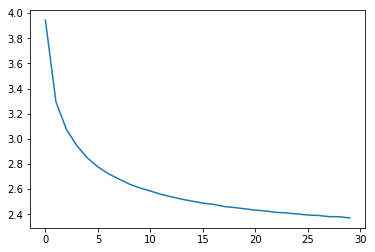

In [83]:
# Plt the losses
p = []
for h in history:
    p.append(h.history['loss'])

plt.plot(p)
plt.show()

In [ ]:
# model = load_model('./model_weights/model-.h5')

## Predictions

In [84]:
def predict_captions(image):
    
    input_text = 'startseq'
    for i in range (maxLength):
        sequences = [word_to_idx[w] for w in input_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequences], maxlen = maxLength, padding = 'post')
        
        Ypred = model.predict([image, sequence])
        Ypred = Ypred.argmax() #The word having the highest probability - also called Greedy Sampling
        # Another method is Mean Search which involves random selection from the top 3 words
        #print(Ypred)
        word = idx_to_word[Ypred]
        input_text = input_text + ' ' + word
        
        if word == 'endseq':
            break
            
    final_caption = input_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [85]:
for i in range (5):
    idx = np.random.randint(0,1000)
    print("IDX: ", idx)
    image_list = list(encoding_test.keys())
    input_image = image_list[idx]
    print("Input_Image: ", input_image)

IDX:  585
Input_Image:  2310126952_7dc86d88f6.jpg
IDX:  716
Input_Image:  3470951932_27ed74eb0b.jpg
IDX:  363
Input_Image:  3411393875_a9ff73c67a.jpg
IDX:  477
Input_Image:  533483374_86c5d4c13e.jpg
IDX:  460
Input_Image:  373394550_1b2296b8c4.jpg


In [ ]:
encoding_test['3128164023_ebe8da4c32.jpg']

In [ ]:
input_image = '3128164023_ebe8da4c32.jpg'
image = encoding_test[input_image].reshape((1,2048)) #As input is batch_size X 2048

caption = predict_captions(image)
print(caption)
i = plt.imread(imgpath+input_image)
plt.axis('off')
plt.imshow(i)
plt.show()

a black and white dog is jumping through the water


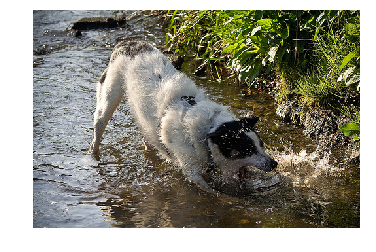

a pack of dogs are running through the grass


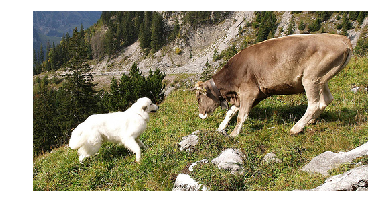

a boy in a blue shirt is jumping on a skateboard


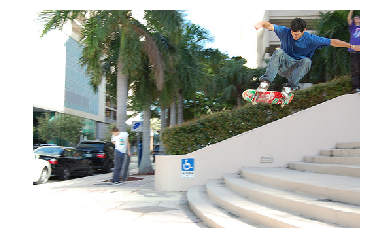

a group of people are gathered in a crowd of people


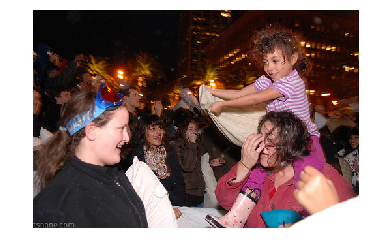

a man with a cast beard and a cast


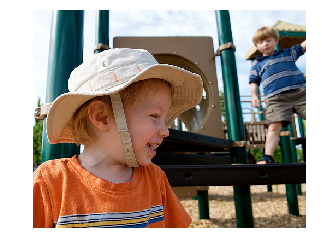

a woman in a blue shirt is standing in front of a crowd of people


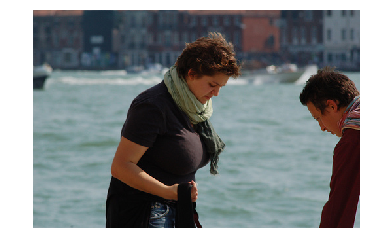

a boy in a blue shirt and blue shirt is about to catch a ball


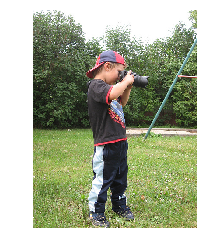

a snowboarder jumps over a snowy hill


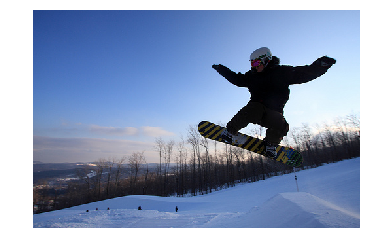

a man in a black jacket is riding a bike in the air


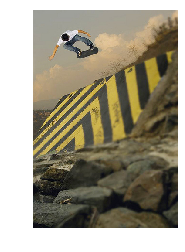

a horse is jumping over a pile of other people watch


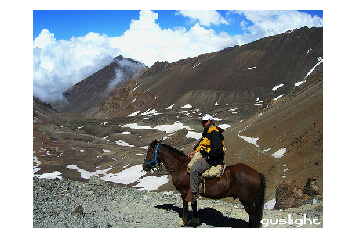

a man in a black shirt is airborne on a skateboard


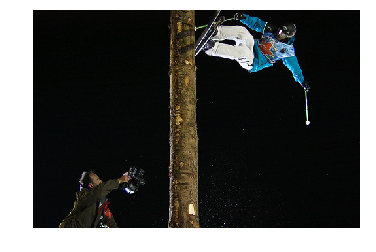

a boy in a blue shirt is running through the grass


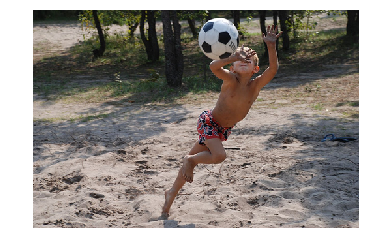

a child in a yellow bathing suit is running through the sprinklers


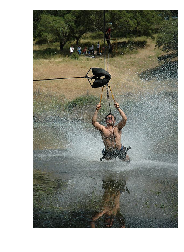

a woman with a pink scarf and sunglasses smiles


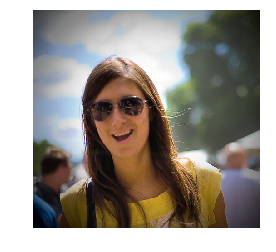

a man in a purple shirt is standing in front of a store shop


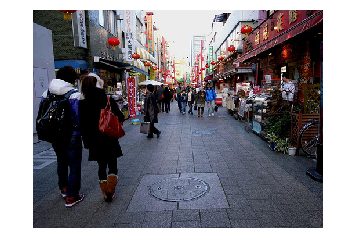

In [86]:
#Pick some random images
for i in range (15):
    idx = np.random.randint(0,1000)
    #print("IDX: ", idx)
    image_list = list(encoding_test.keys())
    input_image = image_list[idx]
    #print("Input_Image: ", input_image)
    image = encoding_test[input_image].reshape((1,2048)) #As input is batch_size X 2048
    
    caption = predict_captions(image)
    print(caption)
    i = plt.imread(imgpath+input_image)
    plt.axis('off')
    plt.imshow(i)
    plt.show()

In [87]:
model.save('final_weights.h5')

In [ ]:
#Pick some random images
for i in range (15):
    idx = np.random.randint(0,1000)
    image_list = list(encoding_train.keys())
    input_image = image_list[idx]

    image = encoding_train[input_image].reshape((1,2048)) #As input is batch_size X 2048
    
    caption = predict_captions(image)
    print(caption)
    i = plt.imread(imgpath+input_image)
    plt.axis('off')
    plt.imshow(i)
    plt.show()

In [ ]:
encoding_train

In [ ]:
for image in encoding_train.keys():
    i = plt.imread(imgpath+image)
    plt.axis('off')
    plt.imshow(i)
    plt.show()

In [ ]:
encoding_train

In [ ]:
for key, arr in train_descriptions.items():
    

In [ ]:
idx_to_word[0]